# **Assignment 3**
## Fasalu Rahman Kottaparambu

IMPORTS

In [1]:
#!/usr/bin/python3

import gymnasium as gym
import ale_py
gym.envs.registration.register_envs(ale_py)
import os
import random
import numpy as np
from collections import deque

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from assignment3_utils import process_frame # Frame preprocessing helper
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
import datetime
import cv2
import matplotlib.pyplot as plt


## **CNN Model for DQN Agent**

This code defines a functional Deep Q-Network (DQN) agent that uses two convolutional neural networks.
It includes functions for building, training, and updating the networks, as well as for epsilon-greedy action selection and model persistence during the learning process.

In [2]:
# --- Hyperparameters ---
gamma = 0.95              # Discount factor for future rewards
epsilon = 1.0             # Initial exploration rate
epsilon_min = 0.05        # Minimum exploration rate
epsilon_decay = 0.995     # Decay factor for epsilon
update_rate = 10          # Steps to update target network

# Global models
model = None
target_model = None

# --- Build CNN model ---
def build_model(state_size, action_size):
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=4, padding='same', input_shape=(84, 80, 4)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4), strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), strides=1, padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='huber', optimizer=Adam())
    return model

# --- Initialize both networks ---
def init_agent(state_size, action_size_value, gamma_value=0.95):
    global model, target_model, gamma, action_size
    gamma = gamma_value
    action_size = action_size_value
    model = build_model(state_size, action_size)
    target_model = build_model(state_size, action_size)
    target_model.set_weights(model.get_weights())
    print("✅ DQN Agent initialized")
    model.summary()

# --- Epsilon-greedy action selection ---
def act(state):
    global epsilon
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

# --- Greedy action (no randomness) ---
def greedy_act(state):
    q_values = model.predict(state, verbose=0)
    return np.argmax(q_values[0])

# --- Replay training using memory samples ---
def replay(batch, batch_size):
    global epsilon
    states, actions, rewards, next_states, done_flags = batch

    q_values = model.predict(states, verbose=0)
    next_q_values = target_model.predict(next_states, verbose=0)

    for i in range(batch_size):
        if done_flags[i]:
            target = rewards[i]
        else:
            target = rewards[i] + gamma * np.max(next_q_values[i])
        q_values[i][actions[i]] = target

    history = model.fit(states, q_values, epochs=1, verbose=0)
    loss = history.history['loss'][-1]

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    return loss

# --- Update target model ---
def update_target_model():
    target_model.set_weights(model.get_weights())

# --- Save and load weights ---
def save_model(name):
    model.save_weights(name)

def load_model(name):
    model.load_weights(name)
    target_model.load_weights(name)

## **Frame Stacking Wrapper**

This code manages a stack of consecutive game frames to provide temporal context for the DQN agent.
It includes functions to initialize, update, and retrieve the stacked frames so the neural network receives a 4-frame state representation instead of a single image.

In [3]:
# --- Frame stack setup ---
num_frames = 4
frames = deque(maxlen=num_frames)

# --- Reset stack (used at episode start) ---
def reset_stack(frame):
    f = process_frame(frame)
    frames.clear()
    for _ in range(num_frames):
        frames.append(f)
    return np.concatenate(list(frames), axis=-1)

# --- Update stack (add new frame) ---
def update_stack(frame):
    f = process_frame(frame)
    frames.append(f)
    return np.concatenate(list(frames), axis=-1)

# --- Get current stack (pad if needed) ---
def get_stack():
    while len(frames) < num_frames:
        frames.append(frames[-1])
    return np.concatenate(list(frames), axis=-1)


## **Replay Buffer**

This code implements an experience replay buffer, a key component for stabilizing Deep Q-Network (DQN) training. It archives the agent's past experiences—each a tuple of (state, action, reward, next state, done flag). The core functionality allows for adding new experiences and sampling random batches, which decorrelates sequential data and improves the efficiency and stability of the learning process.

In [4]:
max_len = 10000
states = deque(maxlen=max_len)
actions = deque(maxlen=max_len)
rewards = deque(maxlen=max_len)
next_states = deque(maxlen=max_len)
done_flags = deque(maxlen=max_len)

def add_memory(self, state, action, reward, next_state, done):
    # Ensure the state and next_state have the correct shape (1, 84, 80, 4)
    self.states.append(state)
    self.actions.append(action)
    self.rewards.append(reward)
    self.next_states.append(next_state)
    self.done_flags.append(done)

def sample_memory(self, batch_size):
    indices = np.random.choice(len(self.states), batch_size, replace=False)
    batch = (
        np.array([self.states[i] for i in indices]).squeeze(),
        np.array([self.actions[i] for i in indices]),
        np.array([self.rewards[i] for i in indices]),
        np.array([self.next_states[i] for i in indices]).squeeze(),
        np.array([self.done_flags[i] for i in indices])
    )
    return batch



## **DQN Main**

This function orchestrates the end-to-end training of a DQN agent on the Pong environment. Its core responsibilities include managing the interaction between the agent and the environment, populating and sampling from a replay memory, updating the network parameters, and periodically synchronizing the target network. Throughout this process, it logs training progress by monitoring rewards and loss.

In [5]:
def dqn_main():


    # --- Hyperparameters ---
    gamma = 0.95
    episodes = 20 #change to 200 or 100
    batch_size = 8
    skip_start = 90
    max_len = 10000
    target_update_rate = 10

    # --- Replay Buffer ---
    states = deque(maxlen=max_len)
    actions = deque(maxlen=max_len)
    rewards = deque(maxlen=max_len)
    next_states = deque(maxlen=max_len)
    done_flags = deque(maxlen=max_len)

    def add_memory(state, action, reward, next_state, done):
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        done_flags.append(done)

    def sample_memory(batch_size):
        idx = np.random.choice(len(states), batch_size, replace=False)
        batch = (
            np.array([states[i] for i in idx]).squeeze(),
            np.array([actions[i] for i in idx]),
            np.array([rewards[i] for i in idx]),
            np.array([next_states[i] for i in idx]).squeeze(),
            np.array([done_flags[i] for i in idx])
        )
        return batch

    # --- Environment Setup ---
    env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
    state_size = (84, 84, 4)
    action_size = env.action_space.n

    # --- Initialize DQN Agent (Functional) ---
    init_agent(state_size, action_size, gamma)

    # --- Frame Stack ---
    num_frames = 4
    frames = deque(maxlen=num_frames)

    def preprocess(obs):
        """Convert RGB frame to grayscale and resize (simplified placeholder)."""
        import cv2
        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (80, 84))
        return resized / 255.0

    def reset_stack(obs):
        """Reset stack with the same initial frame repeated 4 times."""
        frame = preprocess(obs)
        frames.clear()
        for _ in range(num_frames):
            frames.append(frame)
        return np.stack(frames, axis=-1)

    def update_stack(obs):
        """Append new frame and return stacked state."""
        frame = preprocess(obs)
        frames.append(frame)
        return np.stack(frames, axis=-1)

    # --- GPU Info ---
    print("GPUs detected:", len(tf.config.list_physical_devices('GPU')))
    for g in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(g, True)

    # --- TensorBoard Logging ---
    log_dir = f"runs/pong/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    writer = tf.summary.create_file_writer(log_dir)

    # --- Tracking Variables ---
    total_steps = 0
    all_rewards = 0
    last5 = deque(maxlen=5)
    episode_scores = []
    episode_returns = []

    # --- Training Loop ---
    for e in range(episodes):
        total_reward = 0
        game_score = 0
        loss = 0

        obs, _ = env.reset()
        state = reset_stack(obs)

        # Skip idle frames
        for _ in range(skip_start):
            env.step(0)

        for t in range(2500):
            total_steps += 1
            # Select action
            action = act(np.expand_dims(state, axis=0))
            next_obs, reward, done, _, _ = env.step(action)
            next_state = update_stack(next_obs)

            # Store in replay buffer
            add_memory(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            game_score += reward

            # Train DQN
            if len(states) > 2000 and total_steps % 25 == 0:
                batch = sample_memory(batch_size)
                loss = replay(batch, batch_size)
                with writer.as_default():
                    tf.summary.scalar('Loss', loss, step=e)

            if done:
                all_rewards += game_score
                last5.append(total_reward)
                avg5 = np.mean(last5)
                episode_scores.append(game_score)
                episode_returns.append(total_reward)

                with writer.as_default():
                    tf.summary.scalar('Reward', total_reward, step=e)
                    tf.summary.scalar('Avg_Last5', avg5, step=e)

                print(f"Ep {e+1}/{episodes} | Score: {game_score:.1f} | Avg5: {avg5:.2f} | Steps: {t}")
                break

        # Update target network
        if total_steps % target_update_rate == 0:
            update_target_model()

        # Save model periodically
        if e % target_update_rate == 0:
            fname = f"models/pong_{e}_eps.weights.h5"
            save_model(fname)
            print(f"Saved model: {fname}")

        # Stop early if agent reaches a good score
        if game_score > 15.0:
            print("🏆 Agent reached goal performance, stopping early.")
            break

    # --- Save Final Model ---
    save_model("models/pong_final.weights.h5")

    print("Training completed ✅")

    return episode_scores, episode_returns


In [6]:
episode_scores, episode_returns = dqn_main()


✅ DQN Agent initialized


c:\Users\fasal\OneDrive\Desktop\AIML - 2\RL\CSCN8020_Assignment-3\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 21, 20, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 21, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 10, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7040)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,604,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,686,054 (14.06 MB)

 Trainable params: 3,686,054 (14.06 MB)

 Non-trainable params: 0 (0.00 B)

GPUs detected: 0
Ep 1/20 | Score: -20.0 | Avg5: -20.00 | Steps: 851
Saved model: models/pong_0_eps.weights.h5
Ep 2/20 | Score: -20.0 | Avg5: -20.00 | Steps: 851
Ep 3/20 | Score: -20.0 | Avg5: -20.00 | Steps: 793
Ep 4/20 | Score: -20.0 | Avg5: -20.00 | Steps: 821
Ep 5/20 | Score: -20.0 | Avg5: -20.00 | Steps: 722
Ep 6/20 | Score: -20.0 | Avg5: -20.00 | Steps: 733
Ep 7/20 | Score: -19.0 | Avg5: -19.80 | Steps: 774
Ep 8/20 | Score: -20.0 | Avg5: -19.80 | Steps: 735
Ep 9/20 | Score: -20.0 | Avg5: -19.80 | Steps: 733
Ep 10/20 | Score: -20.0 | Avg5: -19.80 | Steps: 673
Ep 11/20 | Score: -20.0 | Avg5: -19.80 | Steps: 673
Saved model: models/pong_10_eps.weights.h5
Ep 12/20 | Score: -20.0 | Avg5: -20.00 | Steps: 733
Ep 13/20 | Score: -20.0 | Avg5: -20.00 | Steps: 691
Ep 14/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 15/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 16/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 17/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 18/20 | Score: -20.0

## **Plot the required metrics after training**

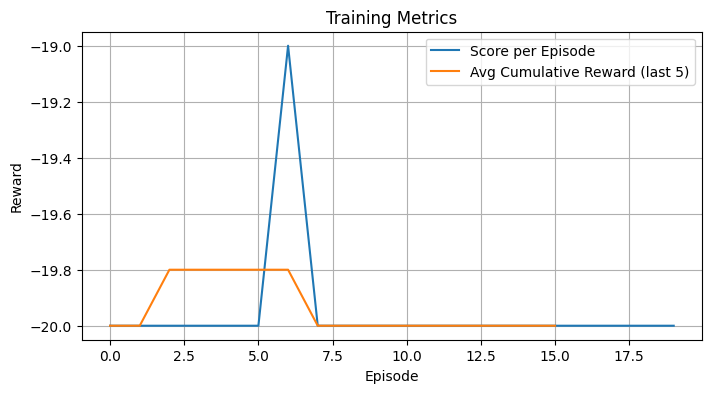

In [7]:

def moving_avg(values, n=5):
    if len(values) < n:
        return np.cumsum(values) / (np.arange(len(values)) + 1)
    return np.convolve(values, np.ones(n)/n, mode='valid')

plt.figure(figsize=(8,4))
plt.plot(episode_scores, label='Score per Episode')
plt.plot(moving_avg(episode_returns, n=5), label='Avg Cumulative Reward (last 5)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Metrics')
plt.legend()
plt.grid(True)
plt.show()

After only 20 episodes of training, the agent is still in the early exploratory phase and has not yet learned a coherent policy. The volatile reward signal indicates actions are largely random, though a slight upward trend in the average reward suggests initial patterns are being recognized.

For substantive improvement, the training should be extended significantly. A minimum of 150 to 200 episodes is recommended. This provides the necessary experience for the agent to stabilize, refine its policy, and consistently improve its performance.

## **Run the deliberate hyperparameter changes and plot the required metrics after training**

In [8]:
# --- Hyperparameter Experiments ---
results = {}

# Batch size experiments
for bs in [8, 16]:
    print(f"\n🔁 Running DQN with batch_size={bs}")
    episode_scores, episode_returns = dqn_main()
    results[f'batch_{bs}'] = (episode_scores, episode_returns)

# Target update rate experiments
for upd in [10, 3]:
    print(f"\n🔁 Running DQN with target_update_rate={upd}")
    episode_scores, episode_returns = dqn_main()
    results[f'update_{upd}'] = (episode_scores, episode_returns)

# --- Plot results separately ---
for key, (scores, rewards) in results.items():
    plt.figure(figsize=(8,4))
    plt.plot(scores, label='Score per Episode')
    plt.plot(moving_avg(rewards, 5), label='Avg Reward (5-episode MA)')
    plt.title(f'Metrics for {key}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()



🔁 Running DQN with batch_size=8
✅ DQN Agent initialized


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 21, 20, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 21, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 10, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7040)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     3,604,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,686,054 (14.06 MB)

 Trainable params: 3,686,054 (14.06 MB)

 Non-trainable params: 0 (0.00 B)

GPUs detected: 0
Ep 1/20 | Score: -19.0 | Avg5: -19.00 | Steps: 751
Saved model: models/pong_0_eps.weights.h5
Ep 2/20 | Score: -20.0 | Avg5: -19.50 | Steps: 673
Ep 3/20 | Score: -20.0 | Avg5: -19.67 | Steps: 877
Ep 4/20 | Score: -19.0 | Avg5: -19.50 | Steps: 751
Ep 5/20 | Score: -19.0 | Avg5: -19.40 | Steps: 751
Ep 6/20 | Score: -20.0 | Avg5: -19.60 | Steps: 733
Ep 7/20 | Score: -20.0 | Avg5: -19.60 | Steps: 733
Ep 8/20 | Score: -20.0 | Avg5: -19.60 | Steps: 673
Ep 9/20 | Score: -20.0 | Avg5: -19.80 | Steps: 735
Ep 10/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 11/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Saved model: models/pong_10_eps.weights.h5
Ep 12/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 13/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 14/20 | Score: -20.0 | Avg5: -20.00 | Steps: 761
Ep 15/20 | Score: -19.0 | Avg5: -19.80 | Steps: 747
Ep 16/20 | Score: -19.0 | Avg5: -19.60 | Steps: 751
Ep 17/20 | Score: -20.0 | Avg5: -19.60 | Steps: 673
Ep 18/20 | Score: -20.0

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 21, 20, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 21, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 10, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 7040)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     3,604,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,686,054 (14.06 MB)

 Trainable params: 3,686,054 (14.06 MB)

 Non-trainable params: 0 (0.00 B)

GPUs detected: 0
Ep 1/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Saved model: models/pong_0_eps.weights.h5
Ep 2/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 3/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 4/20 | Score: -20.0 | Avg5: -20.00 | Steps: 729
Ep 5/20 | Score: -19.0 | Avg5: -19.80 | Steps: 751
Ep 6/20 | Score: -20.0 | Avg5: -19.80 | Steps: 701
Ep 7/20 | Score: -20.0 | Avg5: -19.80 | Steps: 673
Ep 8/20 | Score: -20.0 | Avg5: -19.80 | Steps: 673
Ep 9/20 | Score: -20.0 | Avg5: -19.80 | Steps: 761
Ep 10/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 11/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Saved model: models/pong_10_eps.weights.h5
Ep 12/20 | Score: -20.0 | Avg5: -20.00 | Steps: 701
Ep 13/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 14/20 | Score: -20.0 | Avg5: -20.00 | Steps: 701
Ep 15/20 | Score: -20.0 | Avg5: -20.00 | Steps: 701
Ep 16/20 | Score: -20.0 | Avg5: -20.00 | Steps: 701
Ep 17/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 18/20 | Score: -20.0

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 21, 20, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 21, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 10, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 11, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 7040)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     3,604,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,686,054 (14.06 MB)

 Trainable params: 3,686,054 (14.06 MB)

 Non-trainable params: 0 (0.00 B)

GPUs detected: 0
Ep 1/20 | Score: -20.0 | Avg5: -20.00 | Steps: 692
Saved model: models/pong_0_eps.weights.h5
Ep 2/20 | Score: -19.0 | Avg5: -19.50 | Steps: 752
Ep 3/20 | Score: -19.0 | Avg5: -19.33 | Steps: 766
Ep 4/20 | Score: -20.0 | Avg5: -19.50 | Steps: 673
Ep 5/20 | Score: -20.0 | Avg5: -19.60 | Steps: 673
Ep 6/20 | Score: -20.0 | Avg5: -19.60 | Steps: 733
Ep 7/20 | Score: -20.0 | Avg5: -19.80 | Steps: 733
Ep 8/20 | Score: -19.0 | Avg5: -19.80 | Steps: 751
Ep 9/20 | Score: -20.0 | Avg5: -19.80 | Steps: 855
Ep 10/20 | Score: -20.0 | Avg5: -19.80 | Steps: 673
Ep 11/20 | Score: -20.0 | Avg5: -19.80 | Steps: 673
Saved model: models/pong_10_eps.weights.h5
Ep 12/20 | Score: -20.0 | Avg5: -19.80 | Steps: 673
Ep 13/20 | Score: -20.0 | Avg5: -20.00 | Steps: 793
Ep 14/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Ep 15/20 | Score: -20.0 | Avg5: -20.00 | Steps: 795
Ep 16/20 | Score: -19.0 | Avg5: -19.80 | Steps: 751
Ep 17/20 | Score: -19.0 | Avg5: -19.60 | Steps: 751
Ep 18/20 | Score: -19.0

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 21, 20, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 21, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 11, 10, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 11, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 11, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 7040)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     3,604,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,686,054 (14.06 MB)

 Trainable params: 3,686,054 (14.06 MB)

 Non-trainable params: 0 (0.00 B)

GPUs detected: 0
Ep 1/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673
Saved model: models/pong_0_eps.weights.h5
Ep 2/20 | Score: -20.0 | Avg5: -20.00 | Steps: 673


KeyboardInterrupt: 